# Imports

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from PIL import Image
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util
import cv2

warnings.filterwarnings('ignore')

# Loading Model and Labels

In [2]:
label_path = os.path.join("models", "label_map.pbtxt")
model_path = os.path.join("models", "saved_model")

In [3]:
model = tf.saved_model.load(str(model_path))
model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x2bcb874c0>

# Creating Label Map

In [4]:
def create_category_index(label_path):
    category_index = label_map_util.create_categories_from_labelmap(str(label_path), use_display_name=True)
    cat_dict = {}
    for i, cat in enumerate(category_index):
        cat_dict[i+ 1] = cat
    return cat_dict

In [5]:
category_index = create_category_index(label_path)
category_index

{1: {'id': 1, 'name': 'alpha-romeo'},
 2: {'id': 2, 'name': 'alpha-tauri'},
 3: {'id': 3, 'name': 'alpine'},
 4: {'id': 4, 'name': 'aston-martin'},
 5: {'id': 5, 'name': 'ferrari'},
 6: {'id': 6, 'name': 'haas'},
 7: {'id': 7, 'name': 'mclaren'},
 8: {'id': 8, 'name': 'mercedes'},
 9: {'id': 9, 'name': 'red-bull'},
 10: {'id': 10, 'name': 'williams'}}

# Object Detection

In [6]:
def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

In [7]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis,...]
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
    if 'detection_masks' in output_dict:
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    return output_dict

In [8]:
def apply_inference(model, image):
    image_np = np.array(image)
    output_dict = run_inference_for_single_image(model, image_np)
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=2,
        max_boxes_to_draw=20,
        min_score_thresh=0.1)

    return image_np

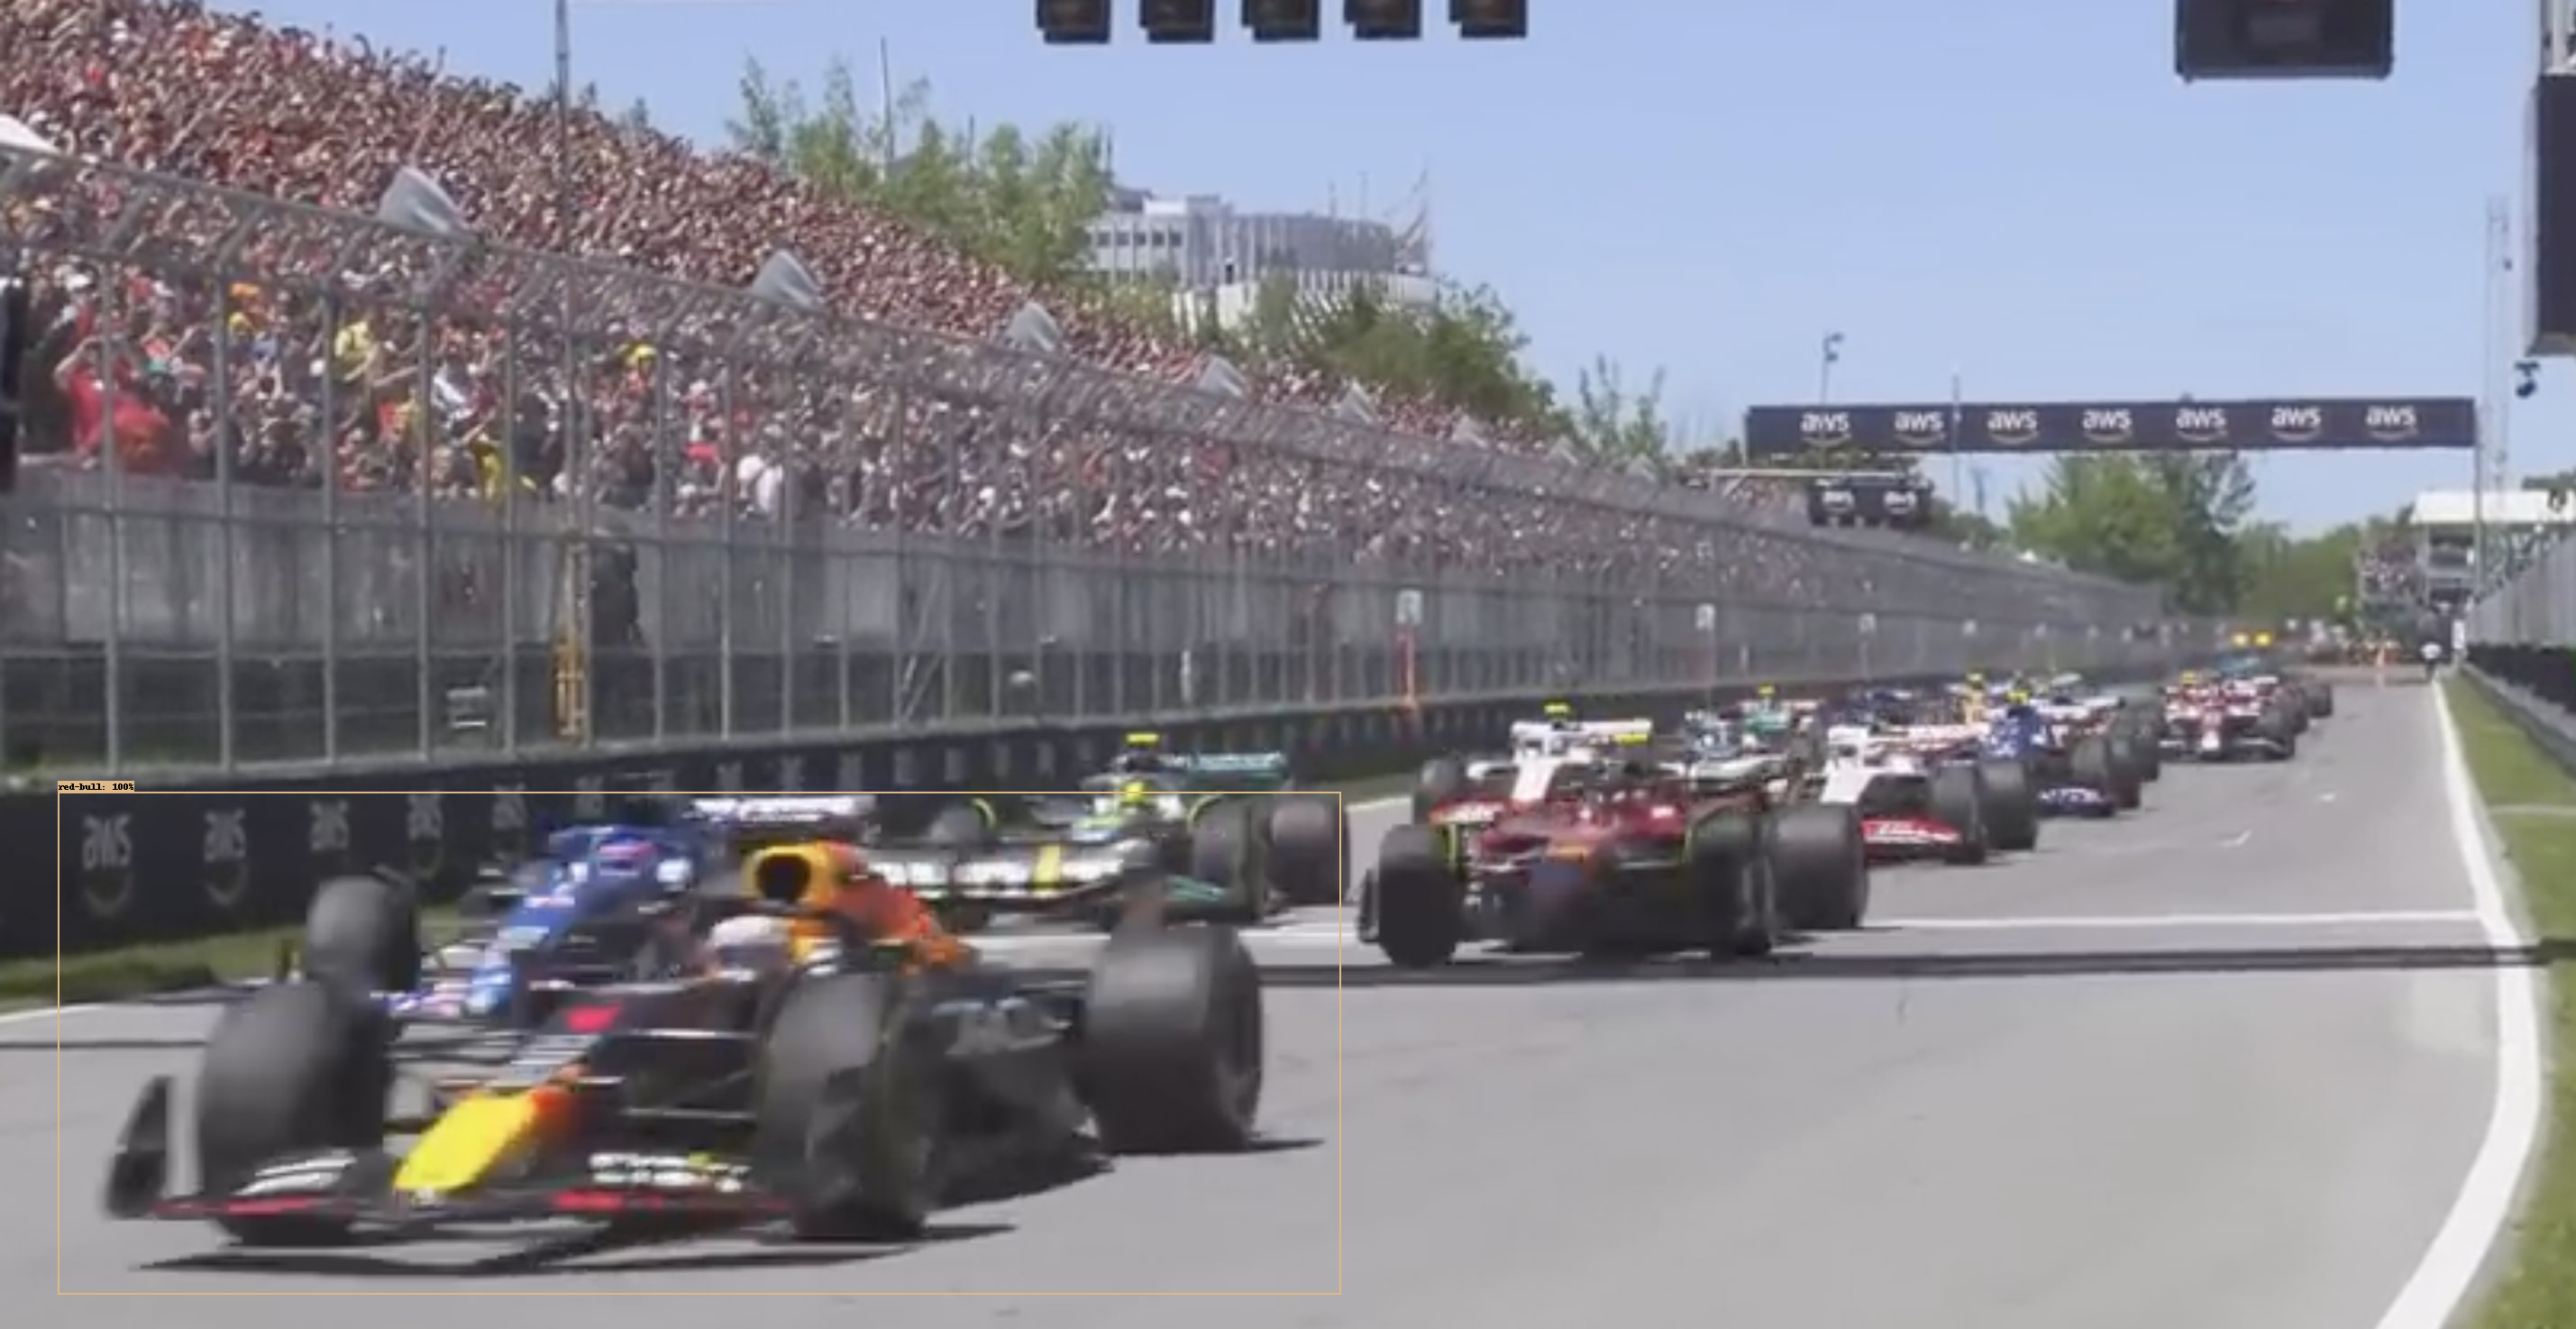

In [9]:
image_path = os.path.join("images_v1", "check.jpg")
res = apply_inference(model, Image.open(image_path))
display(Image.fromarray(res))

# Applying Object Detection To Video

In [10]:
def detect_video(input_path, output_path, model):
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_path, fourcc, 25.0, (854, 480))
    vidcap = cv2.VideoCapture(input_path)
    length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_read, image = vidcap.read()
    count = 0
    while frame_read:
        output_file = apply_inference(model, image)
        out.write(output_file)
        frame_read, image = vidcap.read()
        count += 1
        if count % 100 == 0:
            print(f"Completed: {(count/length) * 100:.2f}%")
    vidcap.release()
    out.release()
    print("Completed: 100%")

In [11]:
input_path = os.path.join("video_v1", "canada.mp4")
output_path = os.path.join("video_v1", "output-full.mp4")

In [12]:
detect_video(input_path, output_path, model)

Completed: 0.92%
Completed: 1.85%
Completed: 2.77%
Completed: 3.69%
Completed: 4.62%
Completed: 5.54%
Completed: 6.46%
Completed: 7.39%
Completed: 8.31%
Completed: 9.23%
Completed: 10.16%
Completed: 11.08%
Completed: 12.00%
Completed: 12.93%
Completed: 13.85%
Completed: 14.77%
Completed: 15.70%
Completed: 16.62%
Completed: 17.54%
Completed: 18.47%
Completed: 19.39%
Completed: 20.31%
Completed: 21.24%
Completed: 22.16%
Completed: 23.08%
Completed: 24.01%
Completed: 24.93%
Completed: 25.85%
Completed: 26.78%
Completed: 27.70%
Completed: 28.62%
Completed: 29.55%
Completed: 30.47%
Completed: 31.39%
Completed: 32.32%
Completed: 33.24%
Completed: 34.16%
Completed: 35.09%
Completed: 36.01%
Completed: 36.93%
Completed: 37.86%
Completed: 38.78%
Completed: 39.70%
Completed: 40.63%
Completed: 41.55%
Completed: 42.47%
Completed: 43.40%
Completed: 44.32%
Completed: 45.24%
Completed: 46.17%
Completed: 47.09%
Completed: 48.01%
Completed: 48.94%
Completed: 49.86%
Completed: 50.78%
Completed: 51.71%
Co